In [2]:
from pygam import LinearGAM, s
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

After importing the needed libraries we start by defining the $\chi^2$ which we will need later

In [3]:
def chisq(obs, exp, error):
    return np.sum(np.square(obs - exp) / np.square(error))

Now we just load the txt file with the data and the effective area and then we plot that effective area.

In [4]:
fileEA = np.loadtxt('EffArea.txt', skiprows = 11)
EffA = pd.DataFrame(fileEA)
EffA = EffA.rename(columns={ 0 : 'E [TeV]', 1: 'Eff area (m^2)'})

#absorption file
file = np.loadtxt('tau_dominguez11.out')
pdfile = pd.DataFrame(file)
pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105'})
E = pdfile['E [TeV]'].to_numpy()
tau = pdfile['tau z=0.20842105'].to_numpy()

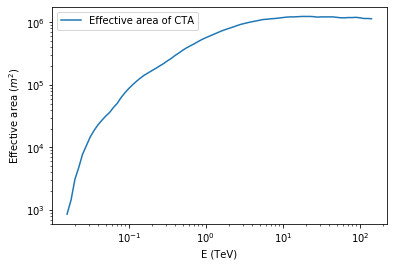

In [5]:
EffaE= EffA['E [TeV]'].to_numpy()
Effa = EffA['Eff area (m^2)'].to_numpy()
plt.plot(EffaE,Effa, label = 'Effective area of CTA')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('E (TeV)')
plt.ylabel(r'Effective area ($m^2$)')
plt.legend()
plt.show()

Let's simulate an absorbed $\frac{dN}{dE}$

In [6]:
K =  8.70e-6 #m−2  s−1  TeV−1
dNdE = K / E**2 #E is divided by 1TeV
m_tau = -tau
dNdEa = dNdE * np.exp(m_tau)

Here we will define the Effective area at the same energy bins as the ones of the $\frac{dN}{dE}$ assuming linear behaviour between the bins of the effective area (a valid approximation)

In [7]:
EffaA2 = np.zeros(len(E[3:37]))
for i in range(len(E[3:37])):
    for j in range(len(EffaE[9:51])):
        if EffaE[j+9] < E[i+3] and EffaE[j+10] > E[i+3]:
            m = (Effa[j+10]-Effa[j+9])/(EffaE[j+10]-EffaE[j+9])
            n = Effa[j+9] - m * EffaE[j+9]
            EffaA2[i] = m * E[i+3] + n

Now we compute the bin size, add Poisson noise to the $\frac{dN}{dE}$ and we transform our $\frac{dN}{dE}$ into a SED and then the log of the SED, while doing the error propagation.

In [8]:
Ebins = np.zeros(len(E))

for i in range(len(E)):
    if i == 0:
        Ehigh = (E[i+1] - E[i])/2
        Ebins[i] = 2*Ehigh
    elif i == (len(E)-1):
        Elow = (E[i] - E[i-1])/2
        Ebins[i] = 2*Elow
    else:
        Ehigh = (E[i+1] - E[i])/2
        Elow = (E[i] - E[i-1])/2
        Ebins[i] = Elow + Ehigh

time = 180000#s
mu = dNdEa[3:37] * EffaA2 * Ebins[3:37] * time 
N = np.random.poisson(mu)
N = N.astype(float)

for i in range(len(N)):
    if N[i] == 0:
        N[i] = mu[i]

dNdE_p = dNdEa[3:37] * N/mu
dNdE_p_u = dNdEa[3:37] * 1/np.sqrt(N)

logE = np.log10(E)

SED = np.square(E[3:37]) * dNdE_p
SED_u = np.square(E[3:37]) * dNdE_p_u
logSED = np.log10(SED)
logSED_u = SED_u / (SED * np.log(10))
w = 1/ np.square(logSED_u)

Here we compare the $\frac{dN}{dE}$ before and after adding the Poisson noise

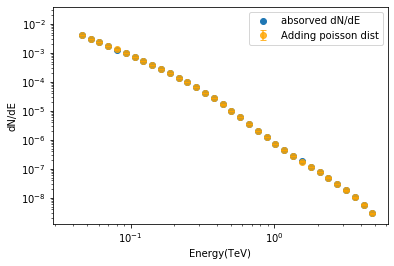

In [9]:
plt.scatter(E[3:37], dNdEa[3:37], label='absorved dN/dE')
plt.errorbar(E[3:37], dNdE_p, yerr = dNdE_p_u, label='Adding poisson dist', capsize=3, fmt='o', alpha=0.8, color='orange')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Energy(TeV)')
plt.ylabel('dN/dE')
plt.legend()
plt.show()

And then we plot the log SED

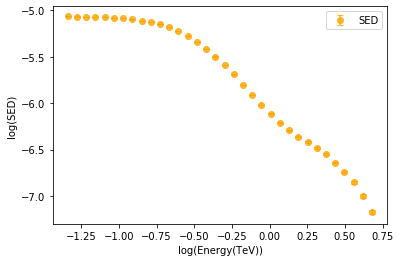

In [10]:
plt.errorbar(logE[3:37], logSED, yerr = logSED_u, label='SED', capsize=3, fmt='o', alpha=0.8, color='orange')
plt.xlabel('log(Energy(TeV))')
plt.ylabel('log(SED)')
plt.legend()
plt.show()

Let's find the best *n_splines* value which we will use for the spline fit

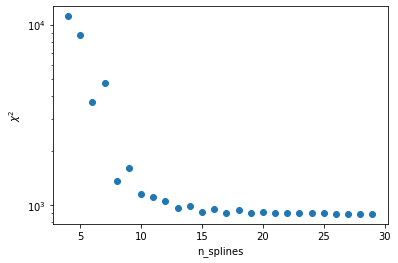

In [11]:
ch = []
for i in range(4,30):
    gamfor = LinearGAM(s(0, constraints='concave', n_splines=i, edge_knots=[max(logE[3:37]),min(logE[3:37])])).fit(logE[3:37], logSED, weights = w)
    chi = chisq(logSED, gamfor.predict(logE[3:37]), logSED_u)
    ch.append(chi)

ch = np.array(ch)
xvals = np.array(range(4,30))
plt.plot(xvals, ch, 'o')
plt.yscale('log')
plt.xlabel('n_splines')
plt.ylabel(r'$\chi^2$')
plt.show()

We plot the fit and the data for the best value of *n_splines*

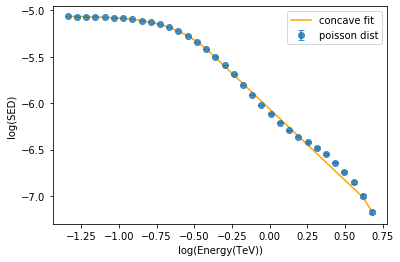

In [12]:
gam = LinearGAM(s(0, constraints='concave', n_splines=26, edge_knots=[max(logE[3:37]),min(logE[3:37])])).fit(logE[3:37], logSED, weights = w)

plt.errorbar(logE[3:37], logSED, yerr = logSED_u, label='poisson dist', capsize=3, fmt='o', alpha=0.8)
plt.plot(logE[3:37], gam.predict(logE[3:37]), label='concave fit', color = 'orange')
plt.xlabel('log(Energy(TeV))')
plt.ylabel('log(SED)')
plt.legend()
plt.show()

In order to check if this was the best spline fit, we plot the residual between the spline and the data

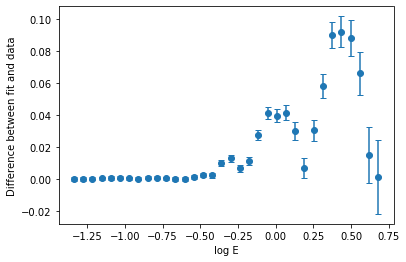

In [13]:
plt.errorbar(logE[3:37], np.abs(gam.predict(logE[3:37])-logSED), yerr=logSED_u, label='Difference', capsize=3, fmt='o',)
plt.xlabel('log E')
plt.ylabel('Difference between fit and data')
plt.show()

Now let's do the likelihood ratio test:

In [14]:
chisqs = []
alphas = []
for i in range(41):
    alpha = round(0.05 * i, 2)
    alphas.append(alpha)
    dNdE2 = dNdE_p * np.exp(alpha*tau[3:37])
    dNdE2_u = dNdE_p_u * np.exp(alpha*tau[3:37])
    SED2 = np.square(E[3:37]) * dNdE2
    SED_u2 = np.square(E[3:37]) * dNdE2_u
    logSED2 = np.log10(SED2)
    logSED_u2 = SED_u2 / (SED2 * np.log(10))
    w2 = 1/ np.square(logSED_u2)
    
    gam2 = LinearGAM(s(0, constraints='concave', n_splines=25, edge_knots=[max(logE[3:37]),min(logE[3:37])])).fit(logE[3:37], logSED2, weights = w2)
    chi2 = chisq(logSED2, gam2.predict(logE[3:37]), logSED_u2)
    chisqs.append(chi2)

And plot it to check if our EBL model was correct. (if it is the minimum of $\chi^2$ should be around $\alpha=1$

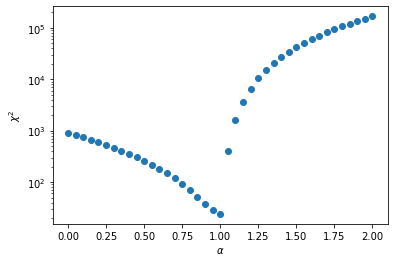

In [15]:

plt.plot(alphas, chisqs, 'o')
plt.yscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\chi^2$')
plt.show()

Why does the $\chi^2$ increase so fast after 1?

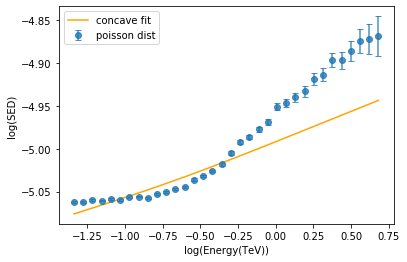

In [16]:
alpha = 1.1
dNdE2 = dNdE_p * np.exp(alpha*tau[3:37])
dNdE2_u = dNdE_p_u * np.exp(alpha*tau[3:37])
SED2 = np.square(E[3:37]) * dNdE2
SED_u2 = np.square(E[3:37]) * dNdE2_u
logSED2 = np.log10(SED2)
logSED_u2 = SED_u2 / (SED2 * np.log(10))
w2 = 1/ np.square(logSED_u2)
    
gam2 = LinearGAM(s(0, constraints='concave', n_splines=25, edge_knots=[max(logE[3:37]),min(logE[3:37])])).fit(logE[3:37], logSED2, weights = w2)
chi2 = chisq(logSED2, gam2.predict(logE[3:37]), logSED_u2)

plt.errorbar(logE[3:37], logSED2, yerr = logSED_u2, label='poisson dist', capsize=3, fmt='o', alpha=0.8)
plt.plot(logE[3:37], gam2.predict(logE[3:37]), label='concave fit', color = 'orange')
plt.xlabel('log(Energy(TeV))')
plt.ylabel('log(SED)')
plt.legend()
plt.show()